<a href="https://colab.research.google.com/github/senorred/IDS-Data-Challenges/blob/master/Norred_Liz_Constructor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clairvoyant Constructor
IDS data challenge, Liz Norred

##Prompt: 
Limit 4 hours. You are a data scientist at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like you to work on forecasting core construction material costs. You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format.
Currently, the company is able to purchase futures contracts in a material for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase.

##Approach:
Data does not appear to be continuous, perform EDA by plotting traces. Traces and Pearson matrices indicates that rebar and steel are correlated in pricing with approximately yearly seasonality. Use interpolation imputation to create a continuous signal. Autocorrelation analysis confirms that rebar and steel have strong correlation and seasonality, but also suggests that concrete has comparable yearly seasonality and modest correlation. Further analysis is necessary to validate the inclusion of interpolated data. Split/stack plots describing each year by month characterize steel/rebar well, concrete modestly. Split stack plots are not sufficient for describing glass and plywood. 

## Conclusions by material:
Steel: Consistent price over time and predictable seasonality. March-Sep lowest average price with minimum in July. 

Rebar: Correlated with steel, but with shorter average valley, minimum in May. May be phase-shifted with Steel.

Concrete: Likely minimum in August, given available data. This prediction is limited by the discontinuous nature of the data, maybe due to a limited purchasing/selling period associated with the commodity. Supplementary price data recommended. 

Glass: Data appears to have slow or hand-set pricing-- would not normally make a recommendation on this data set alone. Appears to have modest general trend increase in price. Would recommend further characterization of moving average and purchasing at point of need.

Plywood: Cyclical patterns of indeterminate origin. May be associated with growing seasons and beneficial to compare similar commodity lumber or agricultural prices. Relatively stationary trend indicates that periodic high price peaks do not last long (3-4 mo) and should be "waited out". 


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


##Import Libraries and data

In [0]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/construction/construction_material_prices_2008_2018.csv',index_col=0)
df.index =pd.to_datetime(df.index, format='%Y-%m-%d', errors='coerce')
df=df[105:]
df.dtypes
df.head()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
2007-06-01,NaN,NaN,22.0,29.033333,8.875000
2007-06-04,NaN,NaN,22.0,29.888889,10.833333
2007-06-05,NaN,NaN,22.0,29.200000,11.166667
2007-06-06,NaN,NaN,22.0,29.200000,9.750000
2007-06-07,NaN,NaN,22.0,28.363636,10.000000


First thing, import the data and set the index to datetime format. Coerce any misbehaving time values to NaT.

##EDA graphs

In [51]:
ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,6
Number of observations,2840
Total Missing (%),27.3%
Total size in memory,133.2 KiB
Average record size in memory,48.0 B
Numeric,5
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,0


##Plot traces over time

Text(0.5, 1.0, 'Price traces')

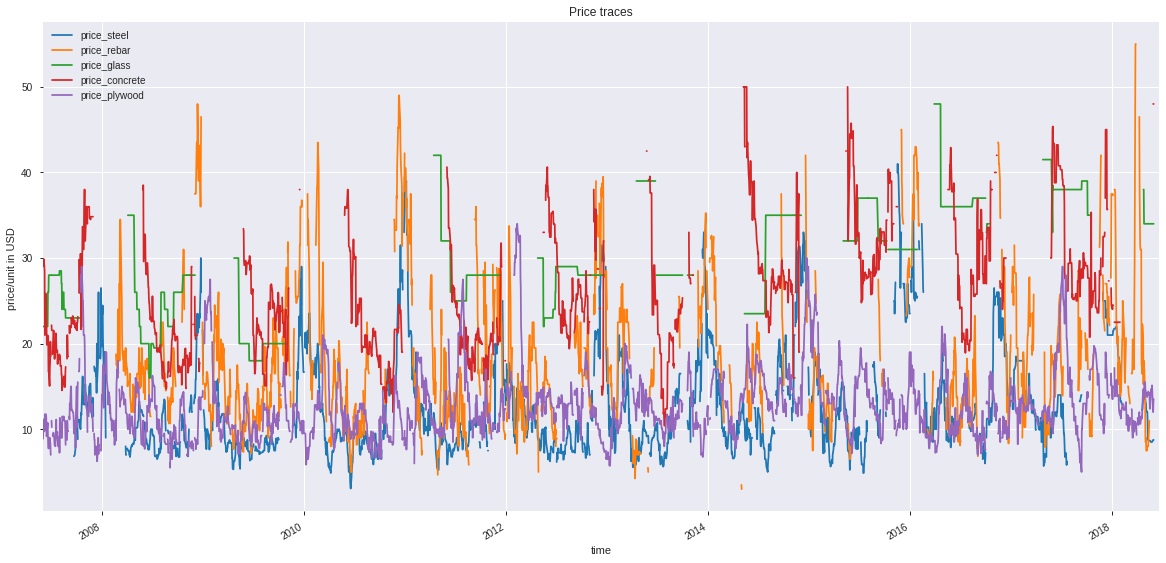

In [52]:
%matplotlib inline
df.plot(figsize=(20,10))
plt.xlabel("time")
plt.ylabel("price/unit in USD ")
plt.title("Price traces")

We can see from the time series traces that this data is discontinuous and has different begin/end dates. However, there is some clear periodicity and possibly some correlation, especially in the price of steel and rebar (which makes intuitive sense). Convieniently, the prices per unit for each iteam appear to be roughly in the same range of values. Let's look at each trace individually (and ignore all the deprecation warnings because we're living on the edge!)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf0514bb00>,
      dtype=object)

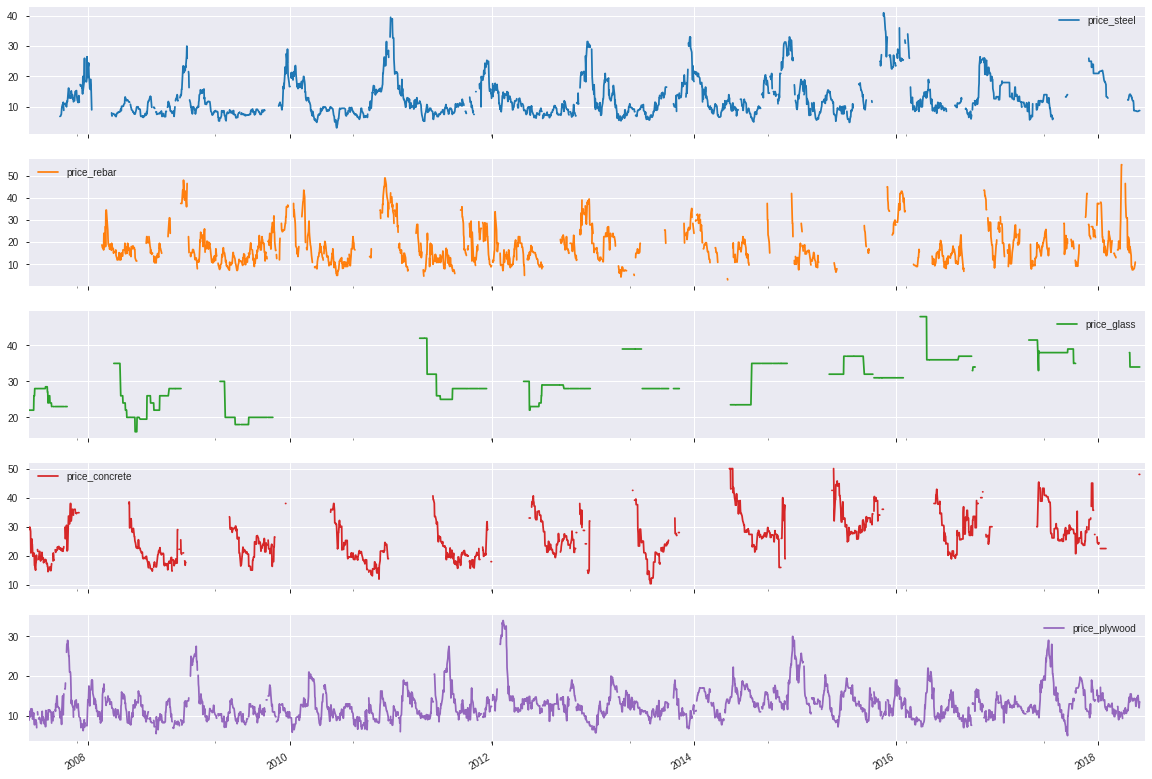

In [53]:
import warnings
warnings.filterwarnings('ignore')
df.plot(subplots=True, figsize=(20,15))

We can see in this graph that the price of steel, rebar, and plywood appear relatively stationary, while the price of concrete and glass may increase generally over time. We can make a better assessment of this by finding the general trend describing each item, using a moving average filter/model. We can also clearly see seasonal peaks in most of these traces, especially in steel, rebar, and plywood. While steel and rebar seem to have consistent 6-month peaks, plywood appears to have a combination of large and small peaks suggesting a combination of seasonal or cyclic effects. We can examine the seasonal effects and relationships between different traces with an autocorrelation analysis or frequency analysis. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf071714a8>,
      dtype=object)

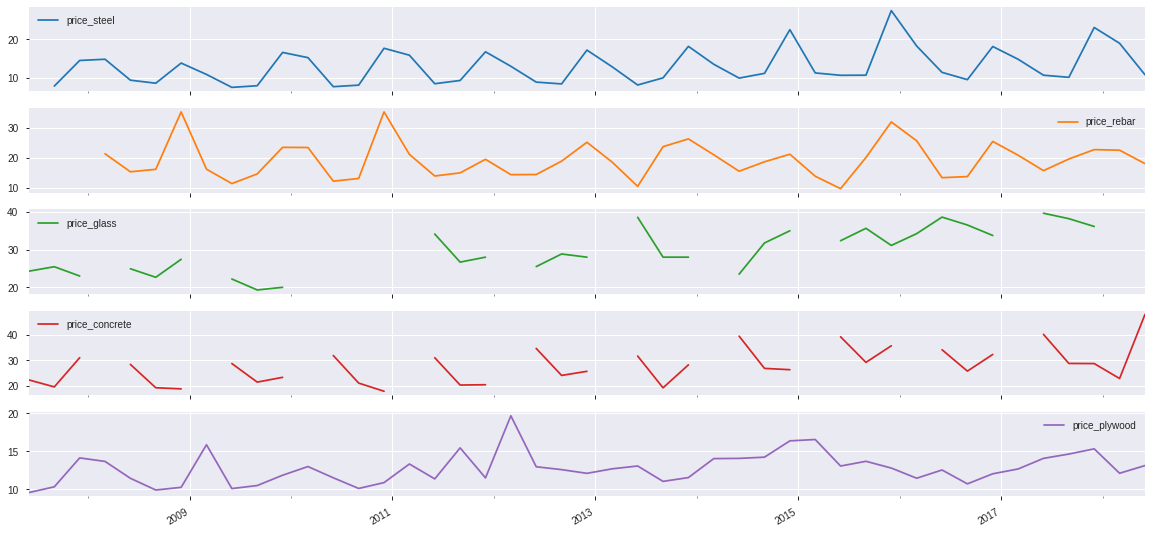

In [54]:
df.resample("3m").mean().plot(subplots=True, figsize=(20,10))

Resampling to a 3 month mean frequency value reveals a very strong relationship between steel and rebar, and perhaps a small increase in the general trend of plywood. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf04fb68d0>,
      dtype=object)

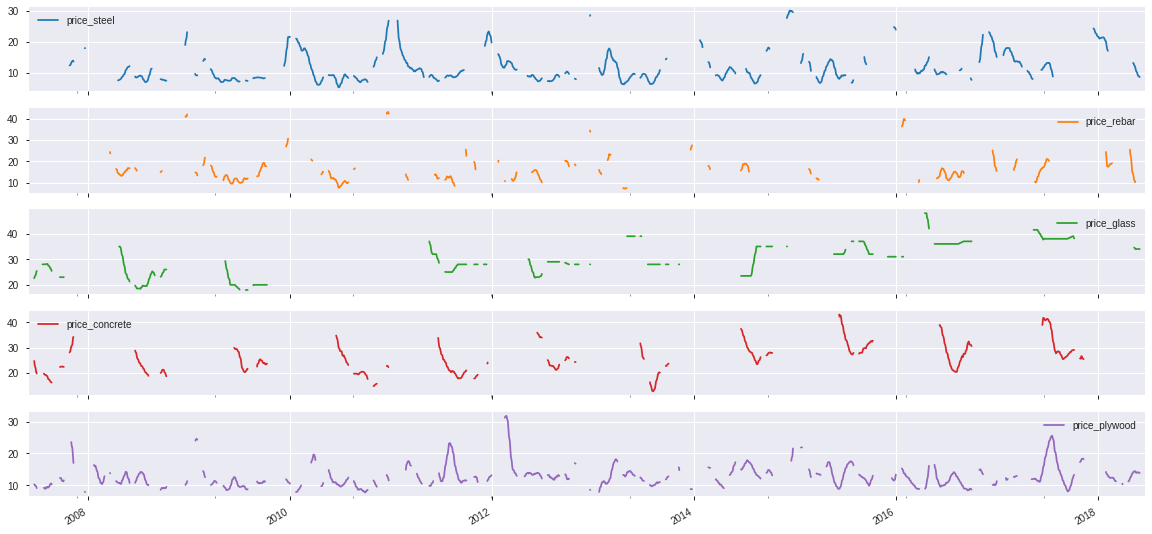

In [55]:
df.rolling(14).mean().plot(subplots=True, figsize=(20,10))


These spaces indicate a problem: we're really going to struggle to do any sort of continuous analysis on this data because it is discontinuous. Tasks like autocorrelation become difficult when calculating lags with Nan values. So we're going to quickly paper over the problem using interpolation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0dab8b6b00>,
      dtype=object)

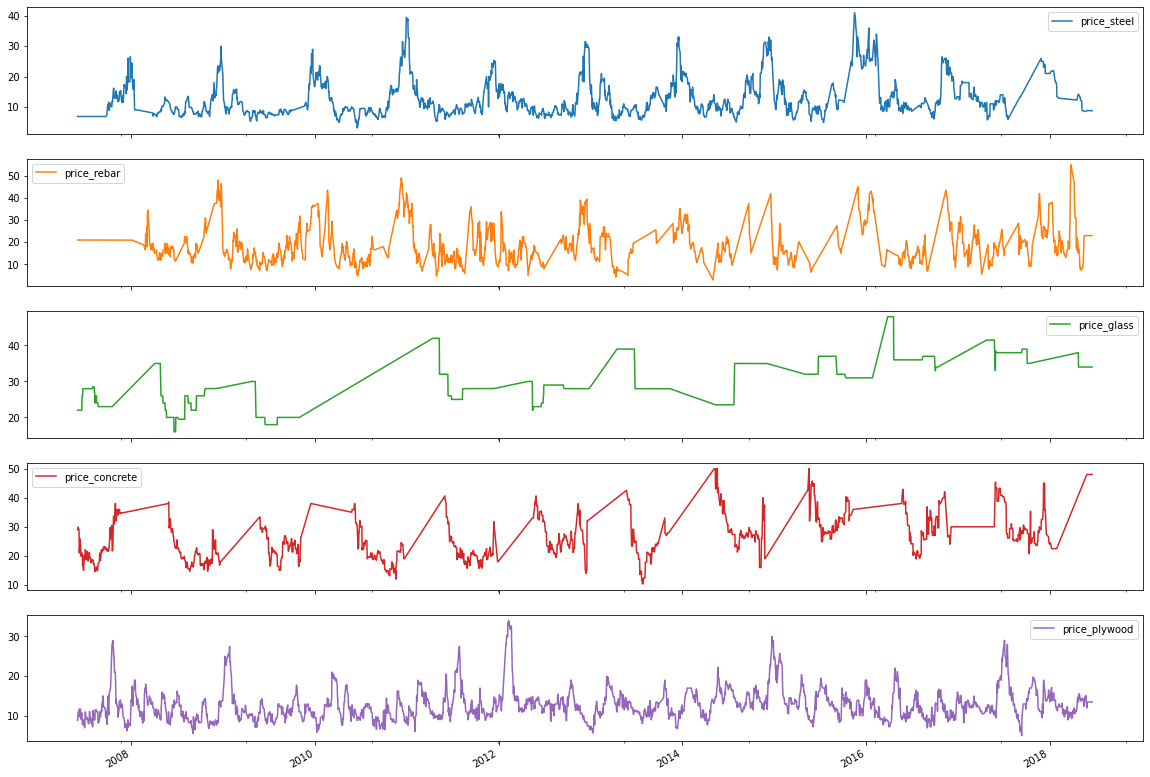

In [7]:
%matplotlib inline
df= df.interpolate(method='time', limit_direction='both', axis=0)
df.plot(subplots=True, figsize=(20,15))

Oh my, that's ugly. But it'll do the stuff I need it to do now, with minimal impact on the data. So...

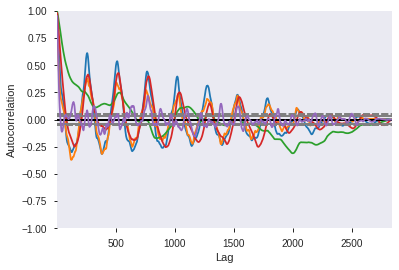

In [78]:
pd.plotting.autocorrelation_plot(df['price_steel']) 
pd.plotting.autocorrelation_plot(df['price_rebar'])
pd.plotting.autocorrelation_plot(df['price_glass'])
pd.plotting.autocorrelation_plot(df['price_concrete'])
pd.plotting.autocorrelation_plot(df['price_plywood'])

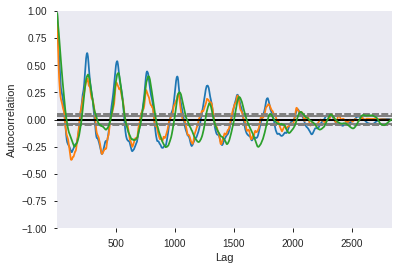

In [80]:
pd.plotting.autocorrelation_plot(df['price_steel']) 
pd.plotting.autocorrelation_plot(df['price_rebar'])
pd.plotting.autocorrelation_plot(df['price_concrete'])

The autocorrelation plots reveal that concrete has a surprisingly strong relationship with steel and rebar, in roughly yearly cycles. This may be partly attributed to the interpolated information, but we could test this by breaking the steel and rebar signals into equivalently sized components as the concrete, and measuring the uninterpolated signal relationship. An autoregressive model should be sufficient to predict these.

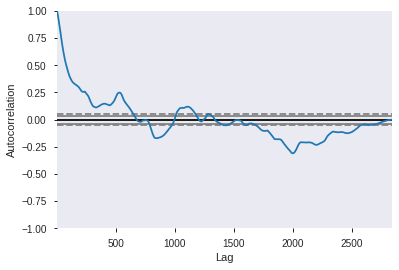

In [81]:
pd.plotting.autocorrelation_plot(df['price_glass'])

The plot for glass prices doesn't really tell us much, except that the trend may need differencing. This signal might not be suited for a monthly stack plot. Will need a full ARIMA. 

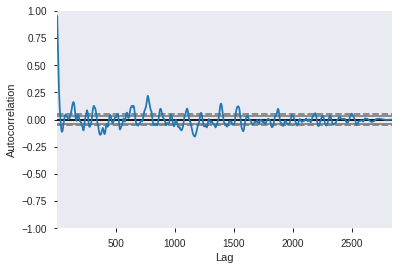

In [91]:
pd.plotting.autocorrelation_plot(df['price_plywood'])

The signal for plywood has much more noise than the previous, but with some significant seasonal peaks. The tallest of these may be associated with a ~2yr cycle.




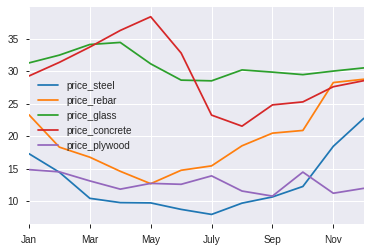

In [102]:
by_month = df.groupby(df.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug','Sep','Oct','Nov','Dec']
by_month.plot()

In [103]:
by_month.head()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
Jan,17.299523,23.292101,31.268201,29.256428,14.848174
Feb,14.445262,18.306406,32.467819,31.357308,14.505285
Mar,10.430671,16.761824,34.101658,33.709269,13.111431
April,9.772629,14.589203,34.419647,36.264148,11.842733
May,9.726542,12.683216,31.125269,38.372185,12.730823


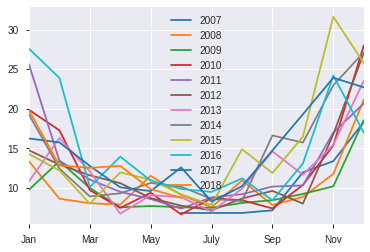

In [107]:
steel= df['price_steel']
d={'2007':steel['2007'], '2008':steel['2008'], '2009':steel['2009'], '2010':steel['2010'],
   '2011':steel['2011'],'2012':steel['2012'],'2013':steel['2013'],'2014':steel['2014'],
   '2015':steel['2015'],'2016':steel['2016'],'2017':steel['2017'],'2018':steel['2018']}
steel_yearly= pd.DataFrame(data=d)
by_month = steel_yearly.groupby(steel_yearly.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug','Sep','Oct','Nov','Dec']
by_month.plot()

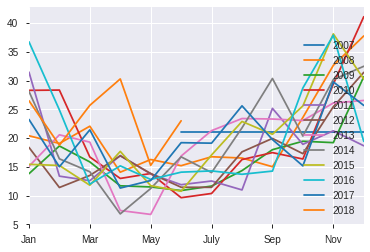

In [108]:
steel= df['price_rebar']
d={'2007':steel['2007'], '2008':steel['2008'], '2009':steel['2009'], '2010':steel['2010'],
   '2011':steel['2011'],'2012':steel['2012'],'2013':steel['2013'],'2014':steel['2014'],
   '2015':steel['2015'],'2016':steel['2016'],'2017':steel['2017'],'2018':steel['2018']}
steel_yearly= pd.DataFrame(data=d)
by_month = steel_yearly.groupby(steel_yearly.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug','Sep','Oct','Nov','Dec']
by_month.plot()

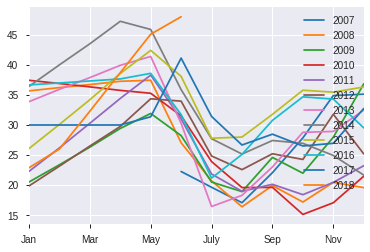

In [109]:
steel= df['price_concrete']
d={'2007':steel['2007'], '2008':steel['2008'], '2009':steel['2009'], '2010':steel['2010'],
   '2011':steel['2011'],'2012':steel['2012'],'2013':steel['2013'],'2014':steel['2014'],
   '2015':steel['2015'],'2016':steel['2016'],'2017':steel['2017'],'2018':steel['2018']}
steel_yearly= pd.DataFrame(data=d)
by_month = steel_yearly.groupby(steel_yearly.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug','Sep','Oct','Nov','Dec']
by_month.plot()

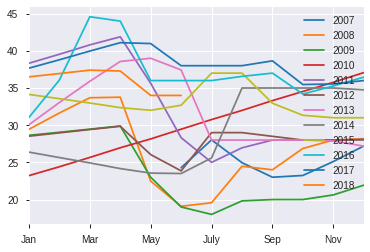

In [110]:
steel= df['price_glass']
d={'2007':steel['2007'], '2008':steel['2008'], '2009':steel['2009'], '2010':steel['2010'],
   '2011':steel['2011'],'2012':steel['2012'],'2013':steel['2013'],'2014':steel['2014'],
   '2015':steel['2015'],'2016':steel['2016'],'2017':steel['2017'],'2018':steel['2018']}
steel_yearly= pd.DataFrame(data=d)
by_month = steel_yearly.groupby(steel_yearly.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug','Sep','Oct','Nov','Dec']
by_month.plot()

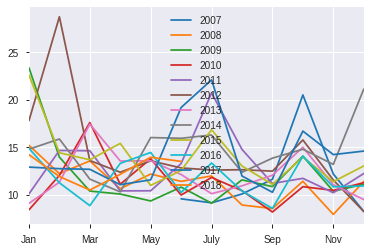

In [113]:
steel= df['price_plywood']
d={'2007':steel['2007'], '2008':steel['2008'], '2009':steel['2009'], '2010':steel['2010'],
   '2011':steel['2011'],'2012':steel['2012'],'2013':steel['2013'],'2014':steel['2014'],
   '2015':steel['2015'],'2016':steel['2016'],'2017':steel['2017'],'2018':steel['2018']}
steel_yearly= pd.DataFrame(data=d)
by_month = steel_yearly.groupby(steel_yearly.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug','Sep','Oct','Nov','Dec']
by_month.plot()

##ARIMA forecasting

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:          price_plywood   No. Observations:                 2840
Model:                    ARMA(10, 0)   Log Likelihood               -4494.168
Method:                       css-mle   S.D. of innovations              1.177
Date:                Tue, 31 Mar 2020   AIC                           9012.336
Time:                        21:16:01   BIC                           9083.755
Sample:                             0   HQIC                          9038.097
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.7698      0.362     35.280      0.000      12.060      13.479
ar.L1.price_plywood      0.9136      0.019     48.707      0.000       0.877       0.950
ar.L2.price_

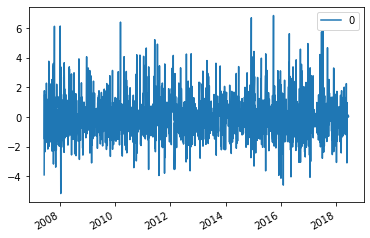

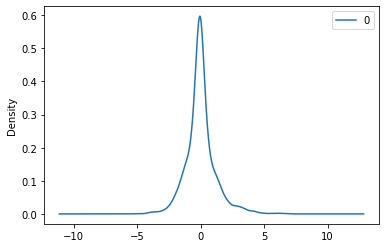

                 0
count  2840.000000
mean      0.000763
std       1.179414
min      -5.152463
25%      -0.527209
50%      -0.065312
75%       0.405970
max       6.840227


In [9]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df['price_plywood'], order=(10,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [0]:
#copypasta!
series = df['price_concrete']
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,0,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=27.059168, expected=26.869565
predicted=26.860557, expected=26.869565
predicted=26.880016, expected=27.851852
predicted=27.815766, expected=27.884615
predicted=27.954715, expected=27.800000
predicted=27.688781, expected=27.769231
predicted=27.782211, expected=26.483871
predicted=26.558656, expected=26.483871
predicted=26.511122, expected=27.968750
predicted=28.075414, expected=29.333333
predicted=29.226921, expected=29.764706
predicted=29.476362, expected=28.575000
predicted=28.483907, expected=28.575000
predicted=28.671371, expected=28.575000
predicted=28.829313, expected=28.000000
predicted=28.026870, expected=27.894737
predicted=27.728783, expected=27.894737
predicted=27.893088, expected=26.333333
predicted=26.323966, expected=26.333333
predicted=26.396169, expected=27.250000
predicted=27.402672, expected=27.200000
predicted=27.186146, expected=27.200000
predicted=27.034279, expected=27.200000
predicted=27.260141, expected=27.100000
predicted=27.174897, expected=27.066667
